Single cell RNA sequencing (scRNA-Seq) is a fascinating way of getting insights into the molecular processes guiding an individual cell. While RNA won't provide the full picture on the inner workings of a cell, proteins, hormones and nutrients will have a say in that too, it certainly is a part of the puzzle. 

For quite some time, researchers have had the ability to not only look at one cell, but hundreds or thousands of cells. Projects such as the [Human Cell Atlas](https://www.humancellatlas.org/) show what is possible. 

Today I am taking a step back and looked for a paper that published a single cell atlas of a size that I can process it in a week at home.

The choice fell on the 2015 Science publication by [Zeisel et al](https://pubmed.ncbi.nlm.nih.gov/25700174/): "Brain structure. Cell types in the mouse cortex and hippocampus revealed by single-cell RNA-seq"


In that publication scRNA-Seq was applied to cells from mouse brain tissues. I will be downloading the datasets and try to recreate figure 1B panels 2-10. Figure 1B panel 1 shows the clustering algorithm implemented by that team, which I might attempt later but have shelved for now.

## Getting the Data

Lucky for me the sequencing data was deposited and can be found in ENA under accession [PRJNA258094](https://www.ebi.ac.uk/ena/browser/view/PRJNA258094). In total over 3000 fastq files are grouped under this accession, each sequencing file seems to be a single cell, meaning the sequencing data has already been conveniently split for later use. 

Looking at one of these fastq files I notice that reads are relatively short (52 bp). According to the paper each read starts with a 6bp UMI followed by 3-5 guanines, followed by the 5’ end of the transcript. Here are 3 reads from one of the datasets to get an idea of what I am talking about:


```txt
@SRR1544698.1 Run0199_AC237YACXX_L2_T1101_C32 length=52
CTAGACGGGGGGAATTCTGGACATTAATTAGGGCTGAAAGCCCTAACTTAAT
+SRR1544698.1 Run0199_AC237YACXX_L2_T1101_C32 length=52
@@@FFFFFHHHDDDDDDEEDDDDDDDDEEEDDDDDDDDDDDDDDDDDDEDDE
@SRR1544698.2 Run0199_AC237YACXX_L2_T1101_C64 length=52
ACACATGGGGGAATTCTCTTGCTTCAACAATAACGTCTCTTTCAGAAGGCAT
+SRR1544698.2 Run0199_AC237YACXX_L2_T1101_C64 length=52
BCCFFFFFHHHHHIIIIIIIIIIIIIIIIIIIIIIGIIIIIIIIIIIIIIII
```

The first read then can be split into these sections:

```txt
  UMI    Gs            Transcript
CTAGAC GGGGG GAATTCTGGACATTAATTAGGGCTGAAAGCCCTAACTTAAT
```

Aligning transcripts directly against a genome might cause issues, as we only have exons here and this might lead to lower quality alignments than expected. As such, to process these reads I will be using software designed to handle both UMIs and gapped alignments.

After a bit of looking around and testing I decided to use the Subread package together with umi_tools. I tried using the STAR aligner but it needed to much memory for creation of the index and other software, such as [Salmon](https://salmon.readthedocs.io/en/latest/salmon.html) is too advanced to allow me to go step by step.

Overall I will be leaning on information provided by the UMI-Tools package on how to process single-cell data with their software, This information can be found here: [https://umi-tools.readthedocs.io/en/latest/Single_cell_tutorial.html](https://umi-tools.readthedocs.io/en/latest/Single_cell_tutorial.html)

### Python Environment

I am using mamba to get a python environment setup quickly. Note that I have my channels configured globally, so I am using bioconda implicitly here.

```sh
mamba create -n reproduce_single_cell python==3.11 uv==0.3.3 samtools subread umi_tools
mamba activate reproduce_single_cell
uv pip install plotnine==0.13.6 pandas==2.2.2 pysam==0.22.1 scipy==1.14.1 numpy==1.25.2 biopython==1.82 pydantic==2.8.2 dask==2024.8.2
```

## Processing scRNA-Seq data

I already know, that I will need to process over 3000 fastq files to get count data. Only then can I move on to the analysis section. As it is quite a commitment to process 3000 files on a single desktop machine, I first set out to process a single file. Once that works, I will scale it up. 


### Getting the References

Besides the sequencing data I will be needing a mouse reference genome and a corresponding map of all the genes on that genome. 

Both of these are easy to find on ENSEMBL.

```sh
wget -P ./data/02/ -c https://ftp.ensembl.org/pub/release-112/fasta/mus_musculus/dna/Mus_musculus.GRCm39.dna.primary_assembly.fa.gz
wget -P ./data/02/ -c https://ftp.ensembl.org/pub/release-112/gtf/mus_musculus/Mus_musculus.GRCm39.112.gtf.gz

# Decompress the data
gunzip ./data/02/Mus_musculus.GRCm39.dna.primary_assembly.fa.gz
gunzip ./data/02/Mus_musculus.GRCm39.112.gtf.gz
```

Before using an aligner the first step is to create an index, this is also true for Subread:

```sh
subread-buildindex -o ./data/02/genome_index ./data/02/Mus_musculus.GRCm39.dna.primary_assembly.fa
```

## Processing the Data

So now we have to index, we can start processing files. 

After some testing I cam up with this script for processing each fastq file from this dataset.
I saved this under `./data/02/align.sh` and will be using it to process the read datasets.

```sh
#!/bin/bash

# Function to check for required dependencies
check_dependencies() {
    for cmd in umi_tools subread-align samtools featureCounts; do
        if ! command -v $cmd &> /dev/null; then
            echo "Error: $cmd is not installed. Please install it and try again."
            exit 1
        fi
    done
}

# Function to display usage
usage() {
    echo "Usage: $0 <reads_file.fastq.gz> <threads> <output_directory> <geneset_file> <genome_index>"
    exit 1
}

# Function to clean up temporary files
cleanup() {
    rm -rf "$TEMP_DIR"
}

# Check for correct number of arguments
if [ "$#" -ne 5 ]; then
    usage
fi

# Set variables
READS_FILE="$1"
THREADS="$2"
OUTPUT_DIR="$3"
GENESET_FILE="$4"
GENOME_INDEX="$5"
TEMP_DIR=$(mktemp -d)
COUNTS_OUTPUT="$OUTPUT_DIR/$(basename "$READS_FILE" .fastq.gz)_counts.tsv.gz"

# Check for dependencies
check_dependencies

# Trap to clean up temporary files on exit
trap cleanup EXIT

# Main processing
{
    UMI_READS="$TEMP_DIR/reads_umi.fastq.gz"
    GROUPED_BAM="$TEMP_DIR/grouped.bam"
    DEDUPLICATED_BAM="$TEMP_DIR/deduplicated.bam"
    ALIGNED_BAM="$TEMP_DIR/aligned.bam"
    SORTED_BAM="$TEMP_DIR/sorted.bam"
    ASSIGNED_SORTED_BAM="$TEMP_DIR/assigned_sorted.bam"
    FEATURECOUNTS_OUTPUT="$TEMP_DIR/featureCounts_output.txt"

    # Extract UMI
    umi_tools extract --bc-pattern=NNNNNN -S "$UMI_READS" -I "$READS_FILE" || { echo "Error in UMI extraction"; exit 1; }

    # Align reads
    subread-align -t 0 -i "$GENOME_INDEX" -r "$UMI_READS" -o "$ALIGNED_BAM" || { echo "Error in alignment"; exit 1; }

    # Sort aligned BAM
    samtools sort "$ALIGNED_BAM" -o "$SORTED_BAM" || { echo "Error in sorting BAM"; exit 1; }
    samtools index "$SORTED_BAM" || { echo "Error in indexing sorted BAM"; exit 1; }
   
    # Count features
    featureCounts -T "$THREADS" -a "$GENESET_FILE" -o "$FEATURECOUNTS_OUTPUT" -R BAM "$SORTED_BAM" || { echo "Error in feature counting"; exit 1; }

    # Sort assigned BAM (using the correct output from featureCounts)
    samtools sort "${SORTED_BAM}.featureCounts.bam" -o "$ASSIGNED_SORTED_BAM" || { echo "Error in sorting assigned BAM"; exit 1; }
    samtools index "$ASSIGNED_SORTED_BAM" || { echo "Error in indexing assigned sorted BAM"; exit 1; }

     # Group UMI reads
    umi_tools group --output-bam -I "$ASSIGNED_SORTED_BAM"  -S "$GROUPED_BAM" || { echo "Error in grouping UMI reads"; exit 1; }
    samtools index "$GROUPED_BAM" || { echo "Error in indexing grouped BAM"; exit 1; }

    # Deduplicate reads
    umi_tools dedup -I "$GROUPED_BAM" -S "$DEDUPLICATED_BAM" || { echo "Error in deduplication"; exit 1; }
    samtools index "$DEDUPLICATED_BAM" || { echo "Error in indexing deduplicated BAM"; exit 1; }


    # Count UMI reads
    umi_tools count --per-gene --gene-tag=XT --assigned-status-tag=XS -I "$DEDUPLICATED_BAM" -S "$COUNTS_OUTPUT" || { echo "Error in UMI counting"; exit 1; }

    # Check if counts file exists
    if [ -f "$COUNTS_OUTPUT" ]; then
        echo "Counts file saved to $COUNTS_OUTPUT"
    else
        echo "Error: Counts file not generated."
        exit 1
    fi
} || {
    echo "An error occurred during processing."
    exit 1
}
```

Here are the steps this script goes trough:

1. Extract the UMI from the first 6 bases
2. Align the reads to the reference using subread
3. Sort and index the resulting bam file
4. Assign each read to a transcript
5. Group all reads assigned to the same transcript
6. Deduplicate within each transcript based on the UMI
7. Report number of unique reads per transcript

Now lets move on and run this for all 3492 datasets.

I first get the table of all datasets, I am simply downloading that from [ENA](https://www.ebi.ac.uk/ena/browser/view/PRJNA258094) using curl:

```sh
curl -o ./data/02/dataset.tsv https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJNA258094&result=read_run&fields=study_accession,sample_accession,experiment_accession,run_accession,library_strategy,read_count,experiment_title,run_alias,fastq_ftp,sra_ftp,sample_alias,sample_title&format=tsv&download=true&limit=0
```

Now I have a TSV file with all the metadata I need. ENA really is amazing.

To download, align and count the datasets one by one, I will be using a simple bash script. It ensures I am not cluttering my disk and am running as many jobs in parallel as my computer can stomach. It also ensures if I have to stop it, that it can continue from where it left of, instead of recomputing results I already have. 

Here it is:

In [ ]:
%%bash
#!/bin/bash

# Set variables
OUTPUT_DIR="./data/02/counts"
THREADS=3
GNUTHREADS=4
GTF="data/02/Mus_musculus.GRCm39.112.gtf"
INDEX="data/02/genome_index"
DATASET="./data/02/dataset.tsv"
ALIGNSH="./data/02/align.sh"

# Create output directory if it doesn't exist
mkdir -p "$OUTPUT_DIR"

# Get the column number of fastq_ftp
HEADER=$(head -n 1 "$DATASET")
FASTQ_COL=$(echo "$HEADER" | tr '\t' '\n' | nl -w1 -s' ' | grep -w 'fastq_ftp' | awk '{print $1}')

if [ -z "$FASTQ_COL" ]; then
    echo "Error: fastq_ftp column not found in the dataset."
    exit 1
fi

# Function to process each line
process_line() {
    line="$1"
    fastqcol=$2

    FASTQFILE=$(echo "$line" | cut -f"$fastqcol")
    FASTQFILE_NAME=$(basename "$FASTQFILE")
    COUNTS_OUTPUT="$OUTPUT_DIR/${FASTQFILE_NAME%.fastq.gz}_counts.tsv.gz"

    # Check if counts file already exists
    if [ -f "$COUNTS_OUTPUT" ]; then
        echo "Counts file already exists for: $FASTQFILE_NAME, skipping."
        return
    fi

    # Download the FASTQ file
    echo "Downloading FASTQ file from: $FASTQFILE"
    wget -c -q "$FASTQFILE" -O "data/$FASTQFILE_NAME" || { echo "Error downloading $FASTQFILE"; exit 1; }

    # Run the align.sh script
    bash "$ALIGNSH" "data/$FASTQFILE_NAME" "$THREADS" "$OUTPUT_DIR" "$GTF" "$INDEX" > /dev/null 2> /dev/null

    # Delete the FASTQ file after processing
    rm "data/$FASTQFILE_NAME"
}

export -f process_line
export OUTPUT_DIR THREADS GTF INDEX ALIGNSH

# Loop through each line in the dataset, skipping the header and use parallel
tail -n +2 "$DATASET"  | parallel -j "$GNUTHREADS" process_line {} $FASTQ_COL

To run this, took me a few days. But in the end I now have 3492 tsv files with counts for each cell. 

## Having a Look

All of the files together will form the count matrix. With genes in rows and cells in columns.

I am loading this with dask, as it is faster than relying on pandas. 

In [3]:
import os
from glob import glob

import dask.dataframe as dd
import pandas as pd
from tqdm import tqdm

dataset_cache_location = "./data/02/count_table.csv.gz"
if os.path.exists(dataset_cache_location):
    df = pd.read_csv(dataset_cache_location, index_col=0)
else:
    # Get all file paths
    files = glob("data/02/counts/*")

    # Initialize an empty list to hold Dask DataFrames
    dataframes = []

    # Loop through each file
    for file in tqdm(files, desc="Loading dataframes"):
        df = dd.read_csv(file, sep="\t", blocksize=None)
        filename = os.path.basename(file)
        new_column_name = filename.split("_")[0]
        df["cell"] = new_column_name
        dataframes.append(df)

    # Now I concatenate the dataframes and construct a full matrix
    combined_df = dd.concat(dataframes)
    combined_df = combined_df.compute()
    df = combined_df.pivot_table(
        index="gene", columns="cell", values="count", fill_value=0
    )
    del combined_df, dataframes
    df.to_csv(dataset_cache_location, index=True)

df.head()

,SRR1544693,SRR1544694,SRR1544695,SRR1544696,SRR1544697,SRR1544698,SRR1544699,SRR1544700,SRR1544701,SRR1544702,...,SRR1548175,SRR1548176,SRR1548177,SRR1548178,SRR1548179,SRR1548180,SRR1548181,SRR1548182,SRR1548183,SRR1548184
gene,,,,,,,,,,,,,,,,,,,,,
ENSMUSG00000000001,0,1,3,0,1,1,2,1,0,2,...,1,0,0,1,0,1,0,0,0,1
ENSMUSG00000000028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
ENSMUSG00000000031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ENSMUSG00000000037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
ENSMUSG00000000049,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The count table I obtained has 49589 rows (genes) and 3492 columns (cells). Using that count table a first good QC plot is to show the number of unique reads per cell:

/home/paul/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
/home/paul/.local/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10


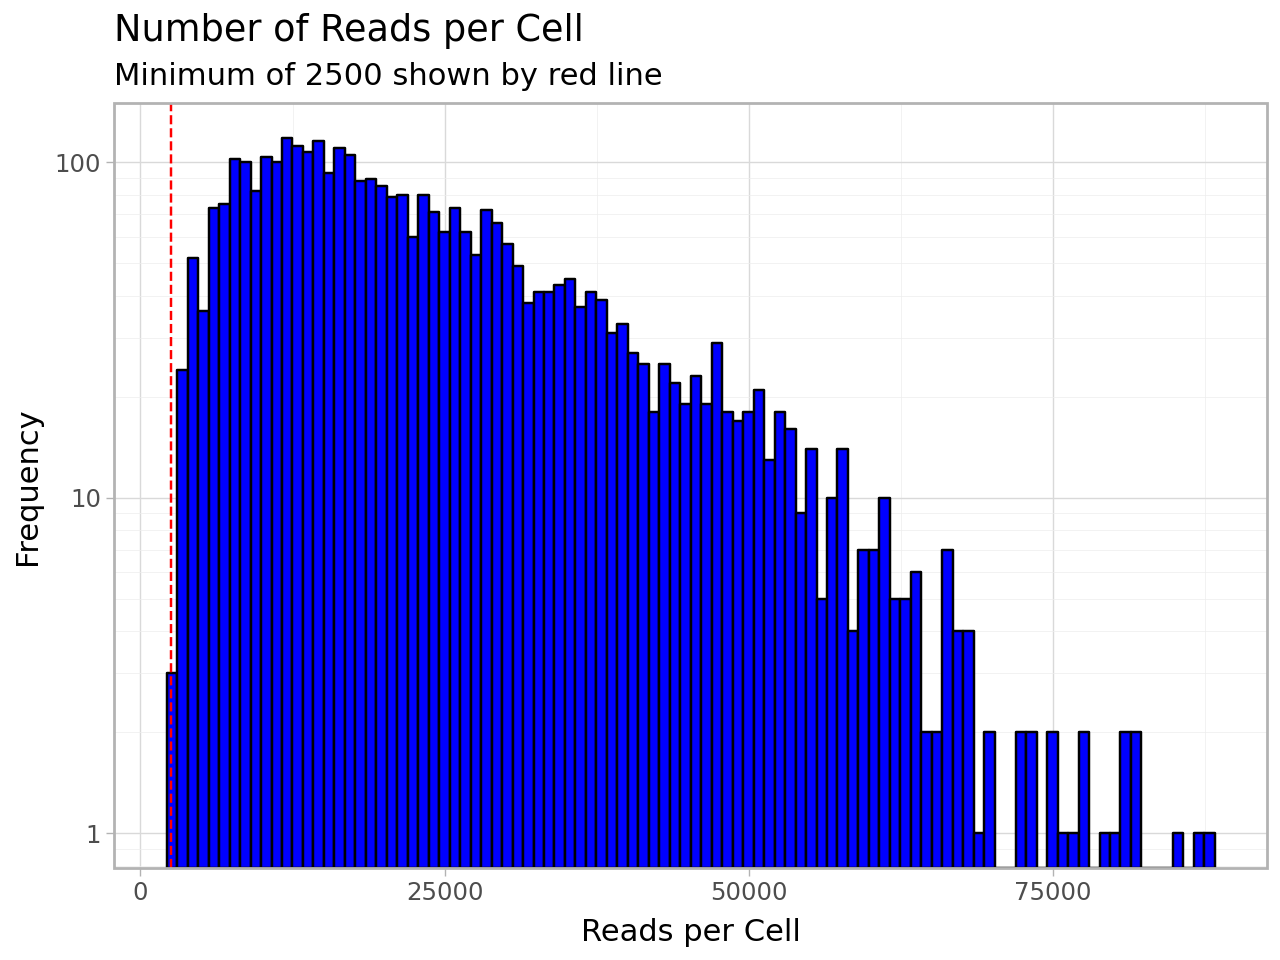

In [4]:
import plotnine as p9

df_colsums = df.sum().reset_index()
df_colsums.columns = ["cell", "gene_count"]
(
    p9.ggplot(df_colsums, p9.aes(x="gene_count"))
    + p9.geom_histogram(bins=100, fill="blue", color="black")
    + p9.labs(
        title="Number of Reads per Cell",
        x="Reads per Cell",
        y="Frequency",
        subtitle="Minimum of 2500 shown by red line",
    )
    + p9.geom_vline(xintercept=2500, color="red", linetype="dashed")
    + p9.scale_y_log10()
    + p9.theme_light()
)

Now I have a table with ENSEMBLE ids but to compare to the authors count able I need gene names, so I will use the GTF I have to quickly get a mapping from ENSEMBLE ID to gene name. This yields a mapping of 57.186 ENSEMBLE ids to their gene names in seconds, and is much faster than blasting the REST API for hours. Also as this is the same GTF file I used during processing earlier, it is guaranteed that all IDs I need are present.

In [5]:
ensemble_mapping = {}

gtf_file = "data/02/Mus_musculus.GRCm39.112.gtf"
gtf_df = pd.read_csv(
    gtf_file, sep="\t", comment="#", header=None, low_memory=False
)
gtf_df.columns = [
    "seqname",
    "source",
    "feature",
    "start",
    "end",
    "score",
    "strand",
    "frame",
    "attribute",
]
gtf_df = gtf_df[gtf_df.feature == "gene"]


def obtain_attributes(attribute_str: str) -> dict:
    attributes = {}
    for e in attribute_str.split(";"):
        e = e.strip()
        if e:
            try:
                a, b = e.split(" ", 1)
                attributes[a] = b.strip('"')
            except ValueError:
                print(f"Warning: Could not parse attribute '{e}'")
    return attributes


for attribute_str in gtf_df.attribute.values:
    attributes = obtain_attributes(attribute_str)
    ensemble_mapping[attributes.get("gene_id")] = attributes.get("gene_name")

all_ids_present = len(
    set(df.index.to_list()).intersection(set(ensemble_mapping.keys()))
) == len(set(df.index.to_list()))

print(
    f"Created mapping for {len(ensemble_mapping)} IDs, which contains all IDs we need: {all_ids_present}"
)

Created mapping for 57186 IDs, which contains all IDs we need: True


This will be helpfull later when I want to have the gene name instead of the ENSEMBL id.

## Reproducing Figure 1B

Figure 1B, shows a t-SNE of the counts. I can quickly plot such a t-SNE using scipy.


In [22]:
import pandas as pd
import plotnine as p9
from sklearn.manifold import TSNE


def compute_tsne(df):
    tsne = TSNE(n_components=2, random_state=12345, perplexity=30)
    tsne_results = tsne.fit_transform(df.drop(columns="cell"))

    # Create a DataFrame for the t-SNE results
    tsne_df = pd.DataFrame(tsne_results, columns=["TSNE1", "TSNE2"])
    tsne_df["cell"] = df["cell"]
    return tsne_df


def plot_tsne(df):
    tsne_plot = (
        p9.ggplot(df, p9.aes(x="TSNE1", y="TSNE2"))
        + p9.geom_point(size=3, stroke=0, fill="#4287f5")
        + p9.geom_point(data=df, size=3, fill="none", stroke=0.1)
        + p9.labs(
            title=f"t-SNE Showing {len(df)} Cells",
            subtitle="Each Cell is a Point",
            x="t-SNE Component 1",
            y="t-SNE Component 2",
        )
        + p9.theme_light()
    )

    return tsne_plot

In [23]:
df_transposed = df.T.copy().reset_index()
df_transposed.rename(columns={"index": "cell"}, inplace=True)
df_transposed = df_transposed.rename_axis(None, axis=1).reset_index(drop=True)
tsne_df = compute_tsne(df_transposed)

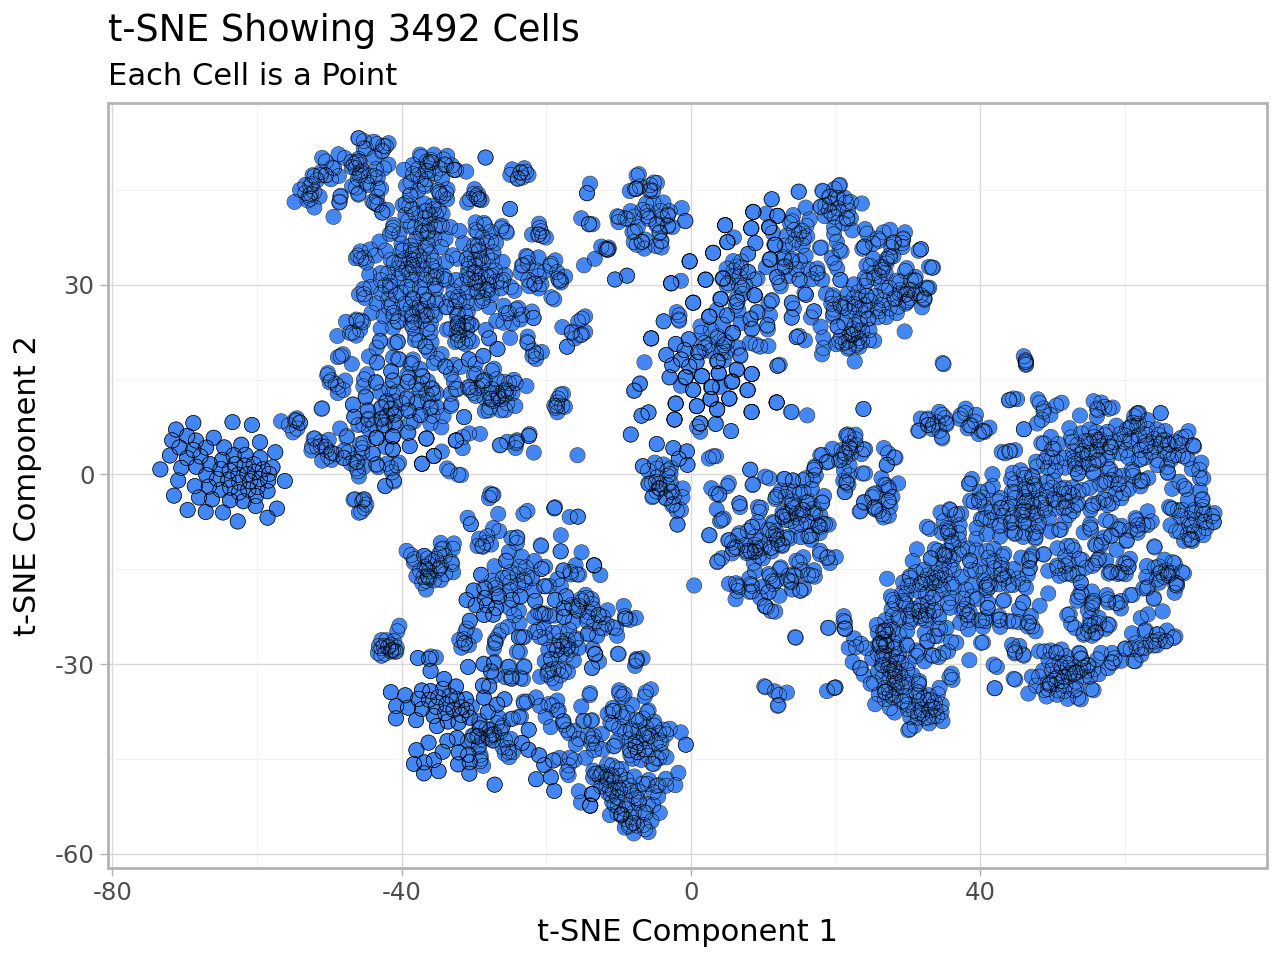

In [24]:
# Make the plot
plot_tsne(tsne_df)

That worked well. But of course I am missing the colouring by intensity. I can add that. For now I will plot the data for the gene `Thy1`:

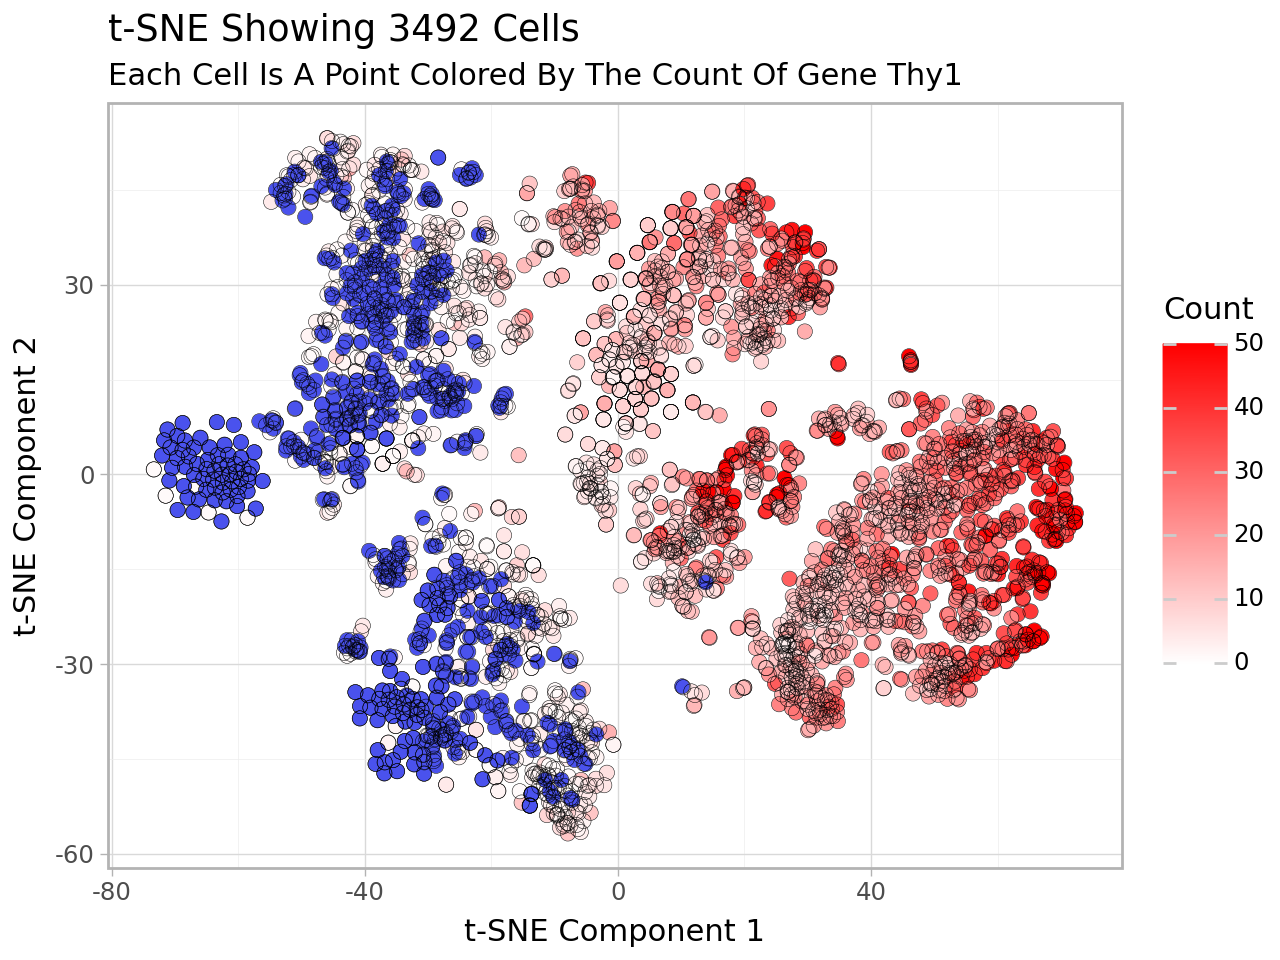

In [39]:
def plot_tsne_intensity(
    df: pd.DataFrame, count_matrix: pd.DataFrame, gene: str, name_mapping: dict
):
    df["intensity"] = count_matrix[name_mapping[gene]]
    quantiles = df["intensity"].quantile([0.01, 0.99]).values.tolist()
    plot_data = df[df["intensity"] > 0]

    tsne_plot = (
        p9.ggplot(plot_data, p9.aes(x="TSNE1", y="TSNE2", fill="intensity"))
        + p9.geom_point(size=3, stroke=0)
        + p9.geom_point(
            data=df[df["intensity"] == 0], fill="#4a52ed", size=3, stroke=0
        )
        + p9.geom_point(data=df, size=3, fill="none", stroke=0.1)
        + p9.labs(
            title=f"t-SNE Showing {len(df)} Cells",
            subtitle=f"Each Cell is a Point colored by the count of gene {gene}".title(),
            x="t-SNE Component 1",
            y="t-SNE Component 2",
        )
        + p9.theme_light()
        + p9.scale_fill_gradient2(
            low="#4a52ed",
            mid="white",
            high="red",
            midpoint=quantiles[0],
            limits=(0, quantiles[1]),
            na_value="red",
            name="Count",
        )
    )

    return tsne_plot


name_mapping = {v: k for k, v in ensemble_mapping.items()}
plot_tsne_intensity(
    tsne_df, df_transposed, gene="Thy1", name_mapping=name_mapping
)

This plot shows that the Thy1 gene, which I choose as it is one of the genes highlighted in Figure 1B, has a very distinct distribution across the cells. Now that the plotting function is working I can make a first draft of the 10 panel figure needed to reproduce figure 1B. I adjust the plotting function to remove all of the labels and legends, so that the figure appears as close to the original as possible:

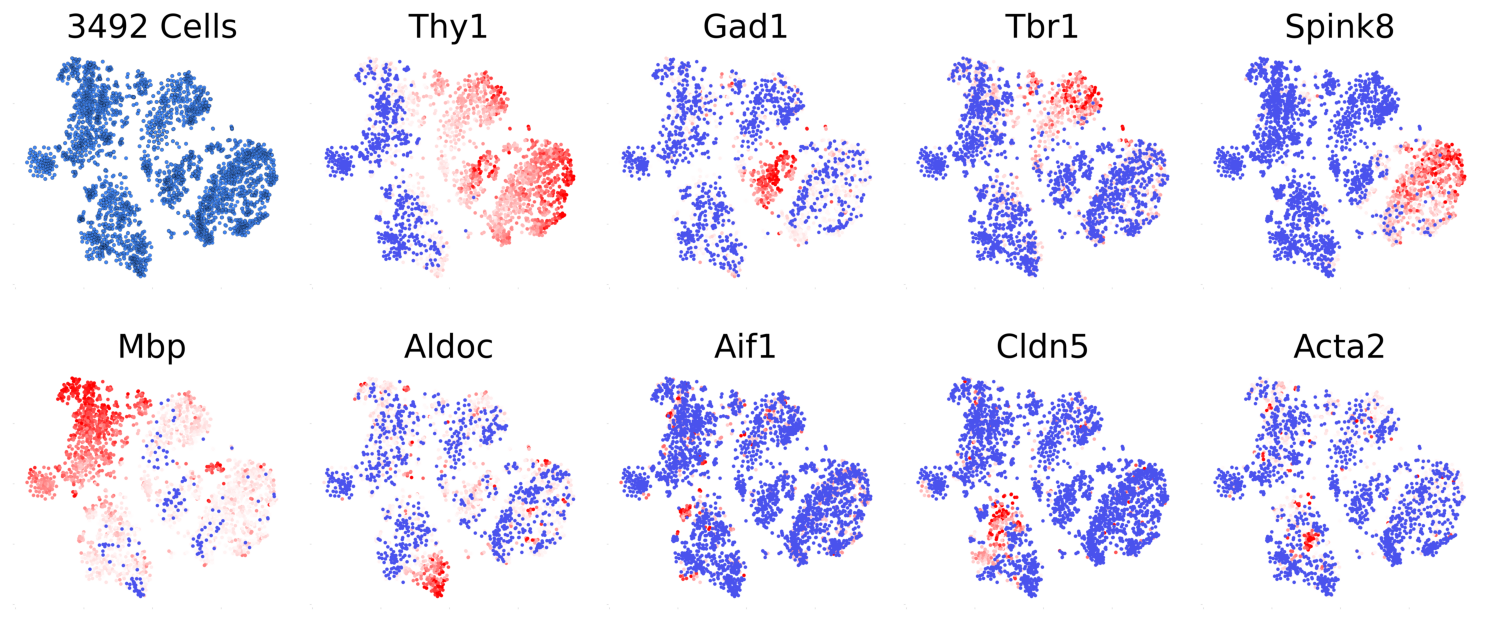

In [52]:
import os
import tempfile

import matplotlib.image as mpimg
import matplotlib.pyplot as plt


def plot_tsne_clean(df):
    tsne_plot = (
        p9.ggplot(df, p9.aes(x="TSNE1", y="TSNE2"))
        + p9.geom_point(size=3, stroke=0, fill="#4287f5")
        + p9.geom_point(data=df, size=3, fill="none", stroke=0.1)
        + p9.labs(
            title=f"{len(df)} Cells",
            x="t-SNE Component 1",
            y="t-SNE Component 2",
        )
        + p9.theme_light()
        + p9.theme(
            plot_title=p9.element_text(size=50),
            axis_title=p9.element_blank(),
            axis_text=p9.element_blank(),
            legend_position="none",
            panel_grid=p9.element_blank(),
            panel_background=p9.element_blank(),
            panel_border=p9.element_blank(),
        )
    )

    return tsne_plot


def plot_tsne_intensity_clean(
    df: pd.DataFrame, count_matrix: pd.DataFrame, gene: str, name_mapping: dict
):
    df["intensity"] = count_matrix[name_mapping[gene]]
    quantiles = df["intensity"].quantile([0.01, 0.99]).values.tolist()
    plot_data = df[df["intensity"] > 0]

    tsne_plot = (
        p9.ggplot(plot_data, p9.aes(x="TSNE1", y="TSNE2", fill="intensity"))
        + p9.geom_point(size=3, stroke=0)
        + p9.geom_point(
            data=df[df["intensity"] == 0], fill="#4a52ed", size=3, stroke=0
        )
        + p9.labs(title=gene)
        + p9.theme_light()
        + p9.scale_fill_gradient2(
            low="#4a52ed",
            mid="white",
            high="red",
            midpoint=quantiles[0],
            limits=(0, quantiles[1]),
            na_value="red",
            name="Count",
        )
        + p9.theme(
            plot_title=p9.element_text(size=50),
            axis_title=p9.element_blank(),
            axis_text=p9.element_blank(),
            legend_position="none",
            panel_grid=p9.element_blank(),
            panel_background=p9.element_blank(),
            panel_border=p9.element_blank(),
        )
    )

    return tsne_plot


def make_10_panel_figure(data: pd.DataFrame):
    df_transposed = df.T.copy().reset_index()
    df_transposed.rename(columns={"index": "cell"}, inplace=True)
    df_transposed = df_transposed.rename_axis(None, axis=1).reset_index(
        drop=True
    )

    tsne_df = compute_tsne(df_transposed)

    name_mapping = {v: k for k, v in ensemble_mapping.items()}
    gene_list_ordered = [
        "Thy1",
        "Gad1",
        "Tbr1",
        "Spink8",
        "Mbp",
        "Aldoc",
        "Aif1",
        "Cldn5",
        "Acta2",
    ]
    image_files = []
    with tempfile.TemporaryDirectory() as folder:
        # first plot is just the cells:
        filename = os.path.join(folder, f"plot_tnse.png")
        plot_tsne_clean(tsne_df).save(
            filename=filename,
            width=6,
            height=6,
            verbose=False,
            dpi=300,
        )
        image_files.append(filename)

        for i, gene in enumerate(gene_list_ordered):
            filename = os.path.join(folder, f"plot_{i}_{gene}.png")
            p = plot_tsne_intensity_clean(
                df=tsne_df,
                count_matrix=df_transposed,
                gene=gene,
                name_mapping=name_mapping,
            )
            p9.ggsave(
                p,
                filename=filename,
                width=6,
                height=6,
                verbose=False,
                dpi=300,
            )
            image_files.append(filename)

        # Create a figure with 2 rows and 4 columns
        fig, axs = plt.subplots(2, 5, figsize=(15, 7))

        # Loop through the first 8 images and display them
        for i in range(2):
            for j in range(5):
                img_index = i * 5 + j
                img_path = image_files[img_index]
                img = mpimg.imread(img_path)
                axs[i, j].imshow(img)
                axs[i, j].axis("off")  # Hide the axes

        # Adjust layout
        plt.tight_layout()

        return plt


plot = make_10_panel_figure(df)
plot.show()

And there it is. Figure 1B without the clustering. There are some differences though I want to go over.

Firstly: The authors describe that before creating the clusters they filtered the data for certain criteria. I am not doing that here, as for the sake of plotting a t-SNE of the expression values this filtering would change the plots only slightly. 

Secondly: If you compare my plot directly with the authors version you will see it looks nothing like it. Why am I claiming it is the same result? t-SNE has stochastic in the name, meaning without knowing the exact state of the algorithm used in the paper I will likely never produce the same plot. Also the software they used to create the t-SNE is not the same that I use now. As such the position of the points will be different. 

Nevertheless if we look at the signal between different genes, it is clear to see that the overarching patterns are the same. 

Thats all I have today. I hope this was interesting to you. 